CSCI 4580-5580: Data Science
Lab 4: NLP Tools

NOTE click near here to select this cell, esc-Enter will get you into cell edit mode, shift-Enter gets you back


Name: Hamza Khokhar

Student ID: 109644074


In this lab we'll explore NLP with the Stanford Parsing suite.

## NOTE:
The Stanford Parser requires the VM you set up in Lab 1. Please revisit that lab (specifically the prelab document) if you run into any issues regarding VM setup. Also this lab will be much easier if you have a shared folder setup for your VM. This was an optional step in the Lab 1 Prelab but it might be worth taking a couple minutes to revisit the document and setup a shared folder before starting this lab.

# Natural Language Analysis of Content

Here we're going to use a parser to extract some "facts" from natural language. The text is from the simplified wikipedia site: http://simple.wikipedia.org. It has been filtered to find sentences about cats. Download the <b>cat.txt</b> file from Canvas into your lab4 directory. 

## Stanford Parser Setup

Download the Stanford parser from Canvas. If you have already downloaded it, you could use the shared folder to transfer it to Ubuntu.

Unpack it with

<pre>tar xvzf stanfordparser.tar.gz</pre>

and then move it to the /opt directory with

<pre>sudo mv StanfordParser /opt</pre>

It will be helpful to have links to the parser scripts from your bin directory. **If you havent already, create a directory ~/bin and add it to your path with ```echo "export PATH=~/bin:$PATH" >> ~/.bashrc``` **
Then
<pre>
cd ~/bin
ln -s /opt/StanfordParser/lexparser.sh lexparser.sh
ln -s /opt/StanfordParser/lexparser-gui.sh lexparser-gui.sh
ln -s /opt/StanfordParser/dependencyviewer/dependencyviewer.sh dependencyviewer.sh
</pre>

These files will be in your path the next time you login. You can logout from the start button at the top right of the VM window. Then log back in again.    

## Running the Parser

From a terminal window, type

<pre>lexparser-gui.sh</pre> 
or alternatively 
<pre>~/bin/lexparser-gui.sh</pre>
 **NOTE: if java is not already installed, you can install it with:**
  <pre>sudo apt install default-jre</pre>
 

This brings up a GUI interface to the Stanford parser. To use it, click on "Load Parser" which brings up a file selection dialog. Navigate to

<pre>/opt/StanfordParser/stanford-parser-3.4.1-models.jar</pre>

and open it.

Then you will see a list of parsers to use. Select

<pre>englishPCFG.ser.gz</pre>

You're now ready to parse some text!

Click on the "Load File" button, and browse to the lab4 directory and load the cat.txt file. Click on "Parse" to parse the current sentence (highlighted in yellow).

### NOTE:
The tags used by the parser are explained in more detail [here](https://gist.github.com/nlothian/9240750). The important parts of speech will be noun, verb, and subject. 


> Q1) Generate two parse tree visualizations for any pair of sentences from cat.txt. The tree should show up in the bottom panel of the Stanford Parser when you click Parse. Screenshot the trees and insert the images below ([see Stack Overflow post on adding image to Jupyter notebook](https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o)). Breifly reflect on the similarity/difference in structure between the two parse trees (for example: how are the parts of speech ordered, is one tree deeper/wider than the other, do the sentences seem like they should have similar/different trees but dont and why?) Make sure to submit the image files along with you notebook when you turn it in!

#### Add Q1 answer here

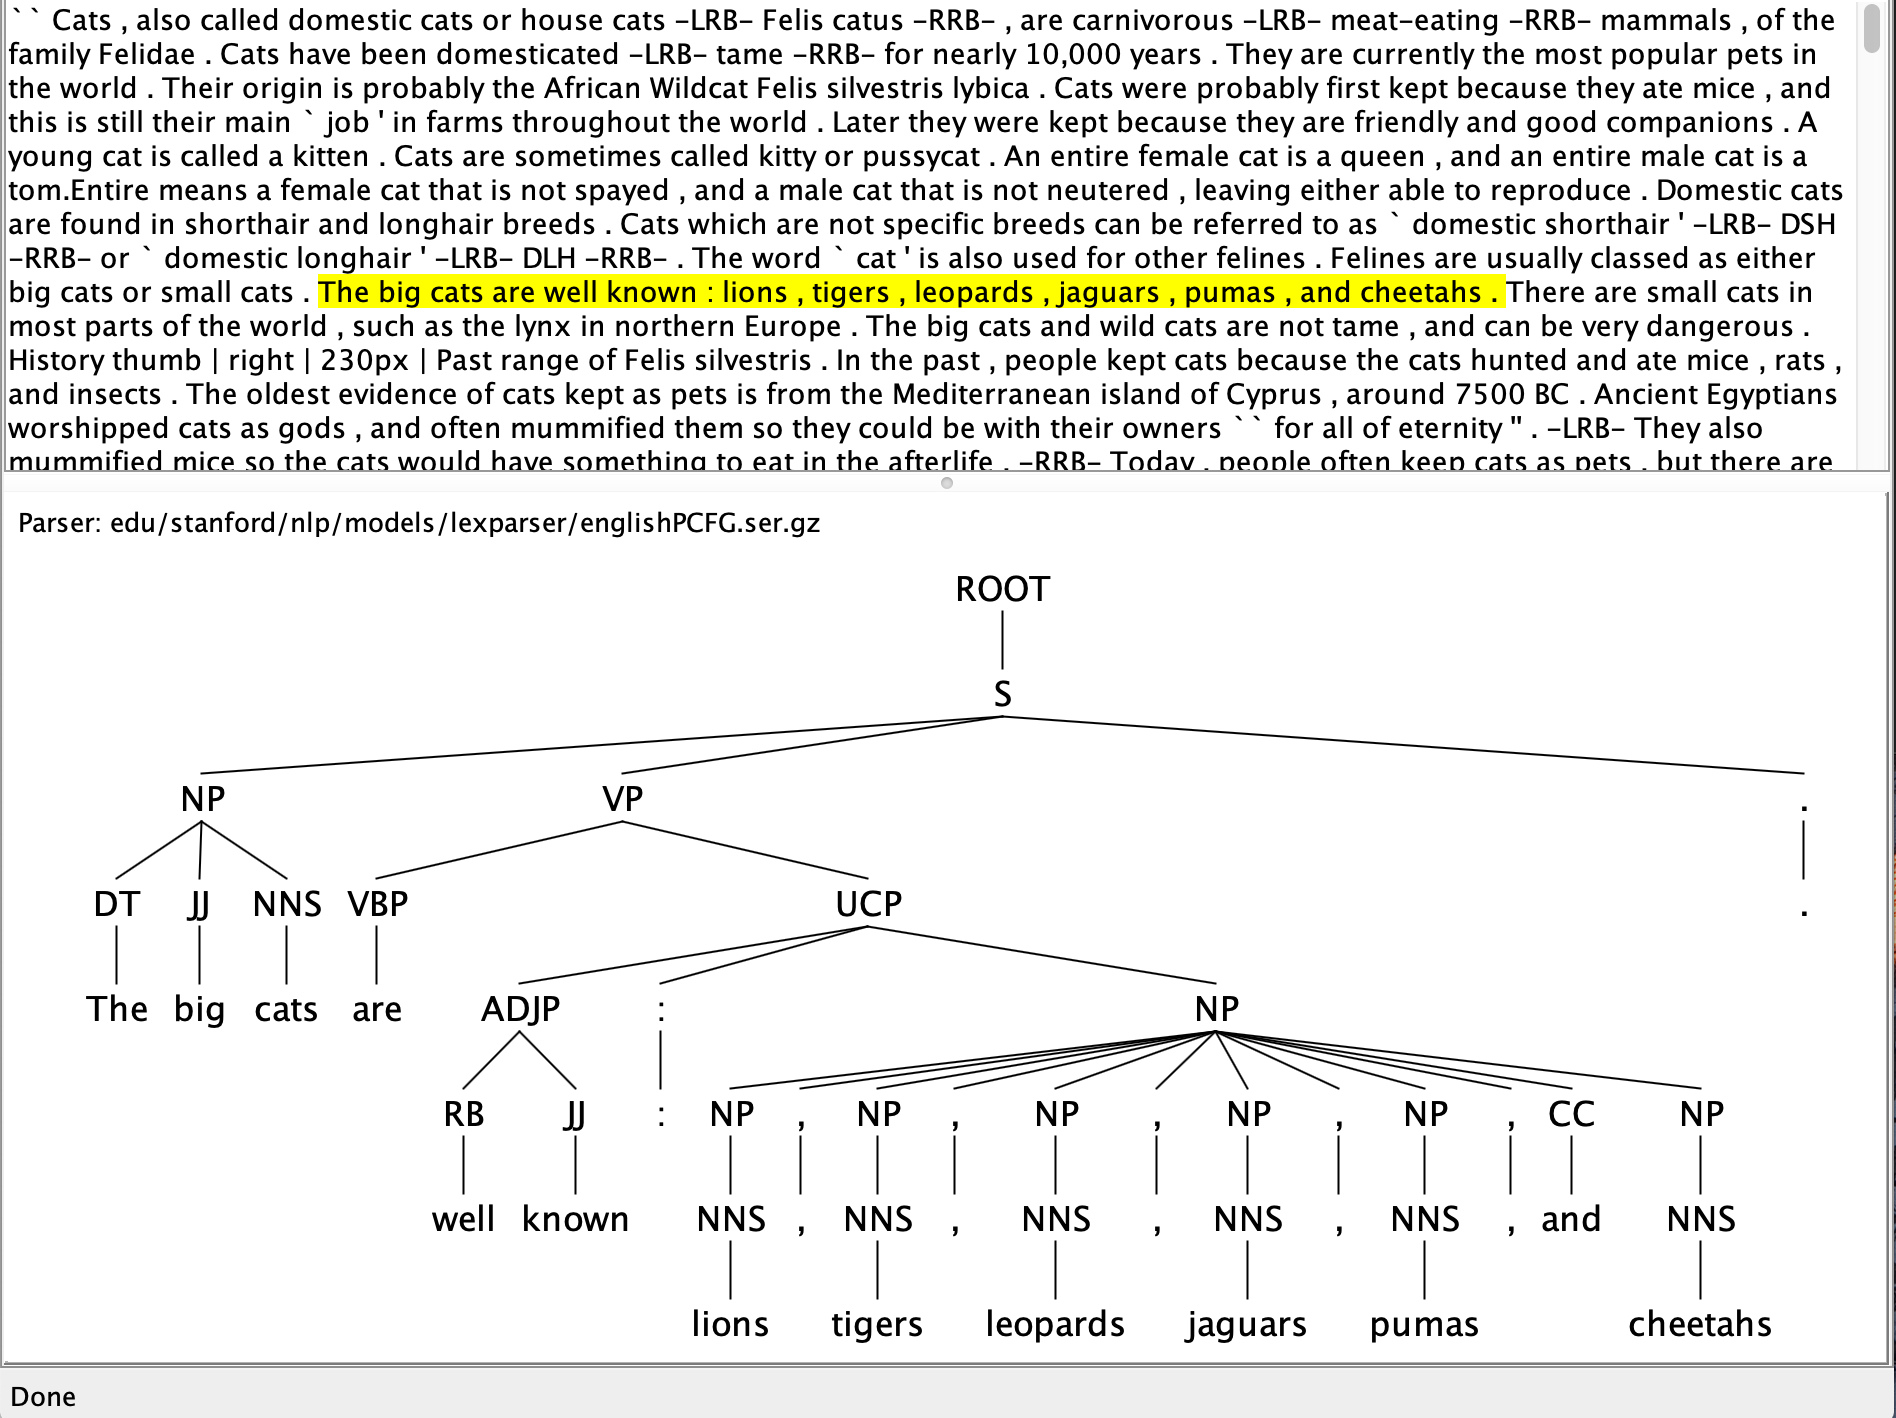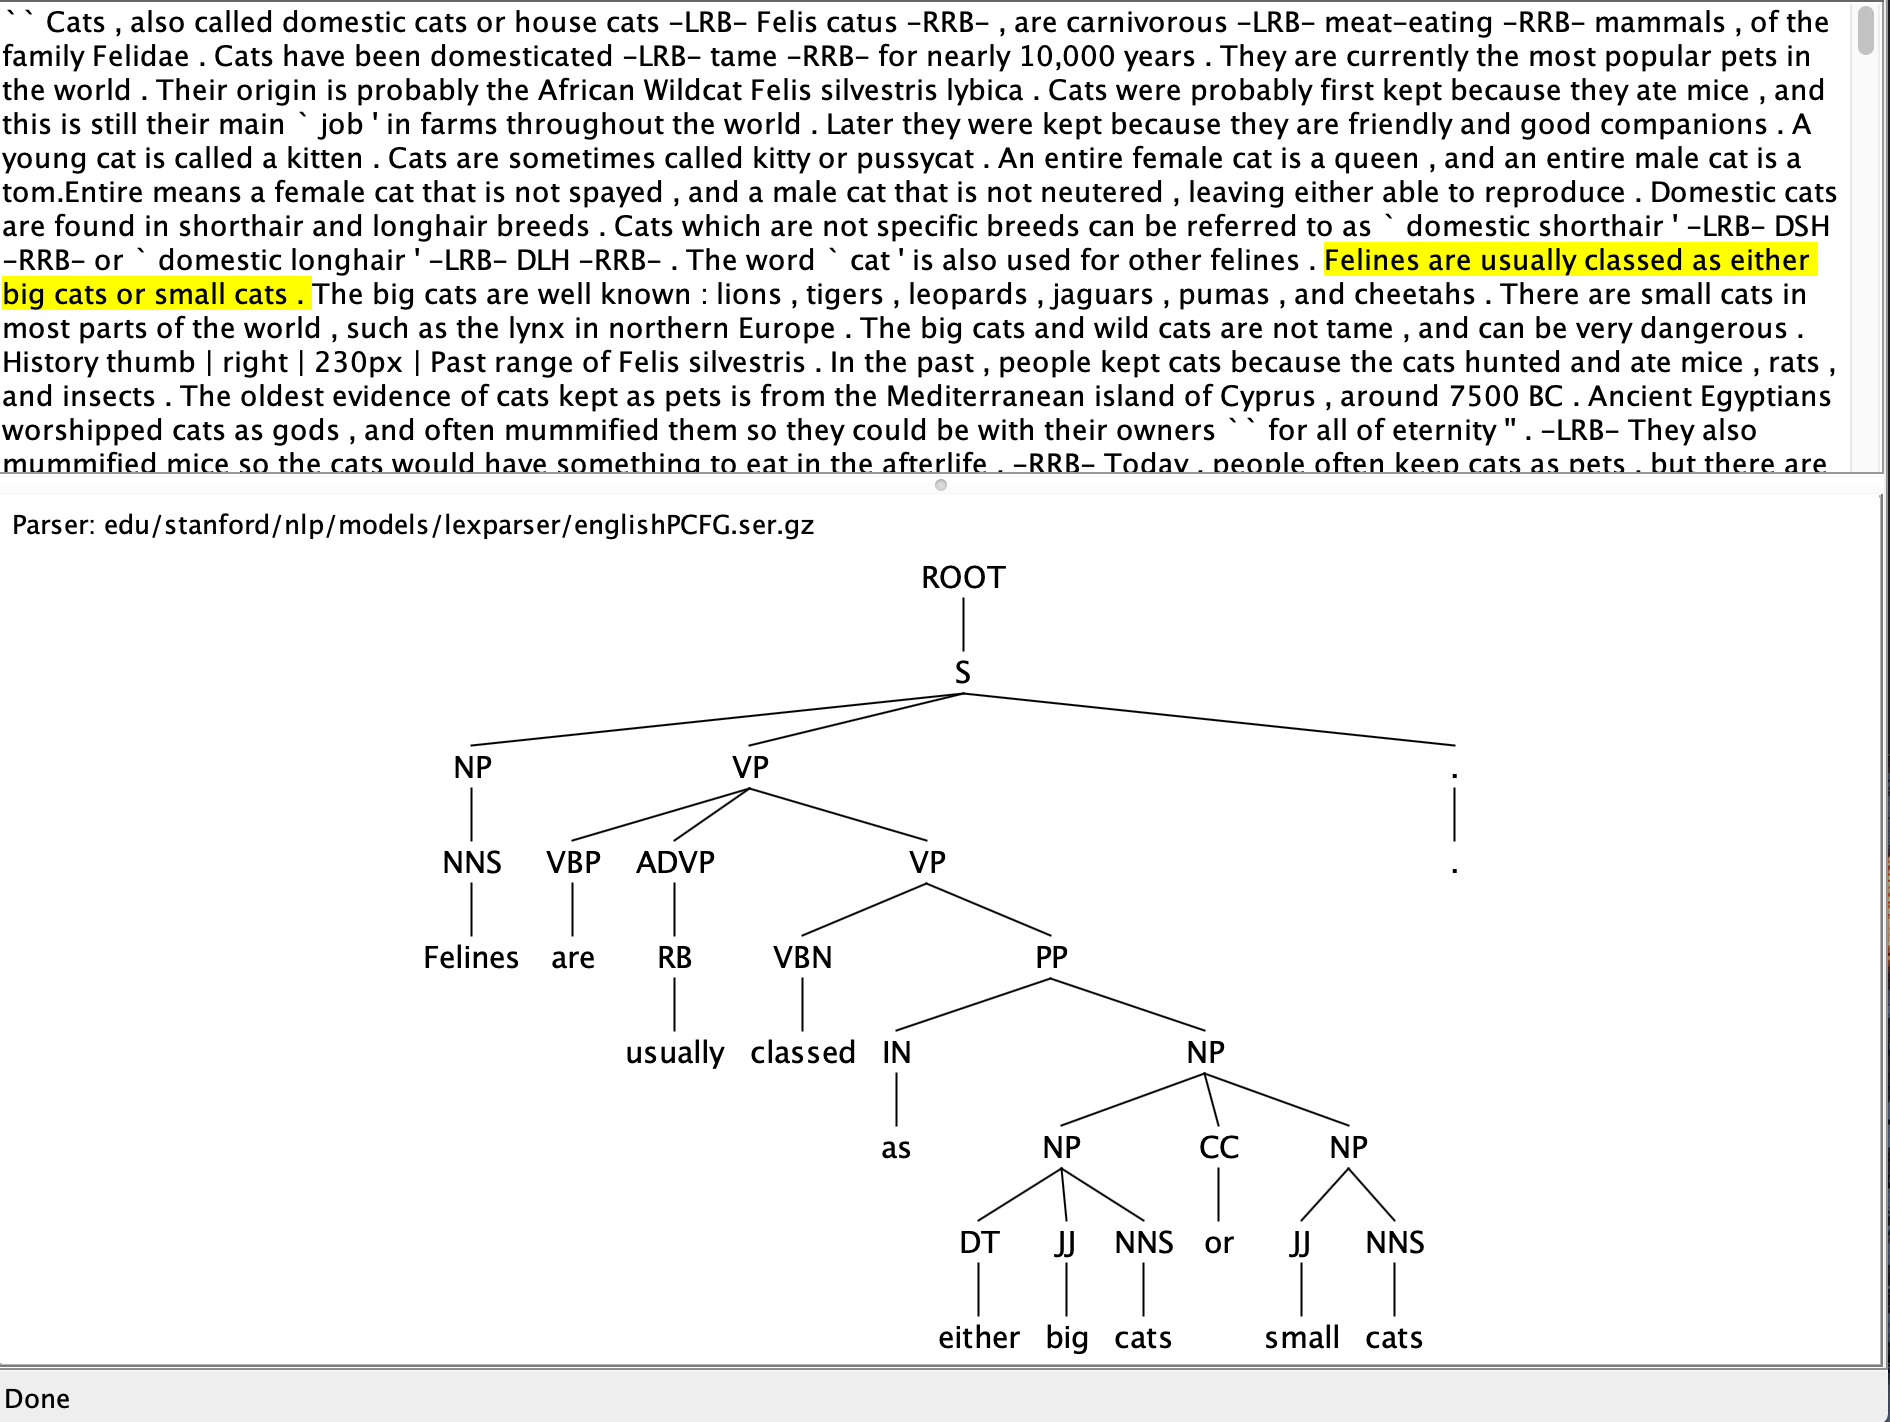

Both of these trees are pretty similar in terms of words but a little different in terms of the shape. The first tree is wider that the second one because it has couple of extra words the second tree is a little deeper maybe the second tree is deeper because it has more verbs(but not entirealy sure).  

## Parsing to XML

We'll parse the cat sentence file to XML. To do this, we'll make a customized version of the parser script. Copy the file:

<pre>/opt/StanfordParser/lexparser.sh</pre>

and save it as:

<pre>/opt/StanfordParser/parsetoxml.sh</pre>

Edit it so that its outputFormat is:

<pre>-outputFormat "xmlTree"</pre>

and add a new option:

<pre>-outputFormatOptions "xml"</pre>

and create an alias to parsetoxml.sh it in your ~/bin directory.
<pre>cd ~/bin</pre>
<pre>ln -s /opt/StanfordParser/parsetoxml.sh parsetoxml.sh</pre>

Now run from your lab4 directory

<pre>parsetoxml.sh cat.txt > cat.xml</pre>

you're ready now to analyze the cat data. We'll use Python's built-in ElementTree parser.

## Working with the XML

You can now copy the cat.xml file out of the VM and into the same directory as this notebook (or a different directory if you prefer, **just be sure to change the path to the xml file below!**)

In [2]:
from lxml import etree
parser = etree.XMLParser(recover=True)
tree = etree.parse('cat.xml',parser) # fix this path if you put the file somewhere else

We can examine the root of this tree:

In [3]:
root=tree.getroot()
root.tag

'corpus'

In [4]:
len(root)

213

In [5]:
root[0].tag

's'

i.e. we have found the first sentence. The xmlTree representation is a little tricky however, as POS tags are stored as attributes of nodes rather than node tags. To get to the actual root node, we need to dig a little deeper (and we'll use the second sentence which is a bit more conventional):

In [6]:
root[1][0][0].attrib['value']

'ROOT'

going down one level gets us to the actual sentence node:

In [32]:
s=root[6][0][0][0]
s.attrib['value']


'S'

and to get its children we can do:

In [8]:
s[:]

[<Element node at 0x7fea54361700>,
 <Element node at 0x7fea54361800>,
 <Element node at 0x7fea54361840>]

This is not too helpful, because the node types are hidden in the value attributes of these nodes. To see them, we can use a python anonymous function and map it over the list.

In [9]:
list(map(lambda x: x.attrib['value'], s[:]))
# of if you prefer list comprehensions: nodes = [x.attrib['value'] for x in s[:]]

['NP', 'VP', '.']

Now let's see if we can find sentences starting with noun phrases containing a given noun. The final function supports a flexible syntax (similar to xpath) for locating elements of given type or attributes. A slash "/" is like a directory specifier, and defines a child node. A double slash "//" specifies any descendent, child, grandchild, great-grandchild, etc. The "node[@value='NP']" specifies a node with the given attribute value.

In [10]:
agent = s.findall("./node[@value='NP']//node[@value='NN']//leaf[@value='cat']")
agent[0].attrib

{'value': 'cat'}

finds all the nodes starting with an 'NP' child of s, and having a 'NN' node above a leaf with 'cat' value.

We can similarly look for a verb in a verb phrase under the root node:


In [11]:
verb = s.findall("./node[@value='VP']//node[@value='VBZ']//leaf[@value='is']")
verb[0].attrib

{'value': 'is'}

Putting these together, we can discover sentences containing a given pair of (agent,action) pairs:

In [12]:
def printnode(node):
    for i in node.findall(".//leaf"):
        print(" " + i.attrib['value']),
    print('')

def testnode(node, agent, action):
    aa = node.findall("./node[@value='NP']//node[@value='NN']//leaf[@value='"+agent+"']")
    bb = node.findall("./node[@value='VP']//leaf[@value='"+action+"']")
    if (len(aa) > 0 and len(bb) > 0):
        printnode(node)    

def agentact(node, agent, action):
    testnode(node, agent, action)
    snodes = node.findall(".//node[@value='S']")
    for snode in snodes:
        testnode(snode, agent, action)

In [13]:
title = 'cat'
agentact(s, title, 'is')

 A
 young
 cat
 is
 called
 a
 kitten
 .



Next we can apply the agentact function to all the sentences in the Wikipedia entry

In [14]:
[agentact(nn[0][0][0], title, 'is') for nn in root]
[] # hide the return bvalue

 A
 young
 cat
 is
 called
 a
 kitten
 .

 An
 entire
 female
 cat
 is
 a
 queen

 an
 entire
 male
 cat
 is
 a
 tom.Entire
 means
 a
 female
 cat
 that
 is
 not
 spayed
 ,
 and
 a
 male
 cat
 that
 is
 not
 neutered
 ,
 leaving
 either
 able
 to
 reproduce

 The
 word
 `
 cat
 '
 is
 also
 used
 for
 other
 felines
 .

 The
 cat
 skull
 is
 unusual
 among
 mammals
 in
 having
 very
 large
 eye
 sockets
 and
 a
 powerful
 and
 specialized
 jaw
 .

 Behaviour
 thumb
 |
 right
 |
 200px
 |
 The
 cat
 on
 the
 right
 is
 fed
 up
 with
 the
 cat
 on
 the
 left

 The
 cat
 creeps
 towards
 a
 chosen
 victim
 ,
 keeping
 its
 body
 flat
 and
 near
 to
 the
 ground
 so
 that
 it
 can
 not
 be
 seen
 easily
 ,
 until
 it
 is
 close
 enough
 for
 a
 rapid
 dash
 or
 pounce
 .

 a
 cat
 is
 relaxed

 a
 male
 cat
 's
 penis
 has
 a
 band
 of
 about
 120-150
 backwards-pointing
 spines
 ,
 which
 are
 about
 one
 millimeter
 long
 ;
 upon
 withdrawal
 of
 the
 penis
 ,
 the
 spines
 rake
 the
 wa

[]

> Q2) Copy the code from the previous cell to the next cell and change the verb to something other than "is" that returns a few sentences. Can you find any sentences that share similar meaning based on their verb alone? Or completely different meaning? Write a breif sentence in a comment about what this could mean for an NLP model and the importance of having enough data.

> Q3) Finish the testnode2 function that returns sentences in which the given adjective (JJ) appears in the cell below, you will need to check for plural nouns (NNS) in addition to singular nouns, which requires a new search with a leaf node of "cats"instead of "cat". Try a few different adjectives (ex: wild, domestic, brown, etc.). Not all adjectives will return results, and you can always check the parse tree in the Stanford parser to check for available adjective-noun pairs. Do the sentences you see make sense? Now try the adjective "dry". Is cat/cats still the subject of the sentences you see returned, if not what is the subject of the sentence? Does this suggest anything to you about how the nuances of languages and how they should be modeled? Write 2-3 sentences in a comment about your observations.


In [78]:
# Q2 code here
[agentact(nn[0][0][0], title, 'called') for nn in root]
[] # hide the return bvalue

 A
 young
 cat
 is
 called
 a
 kitten
 .



[]

I canged the verb from 'is' to 'called' and it seems like the sentence did make sense. But in the world of data science or machine learning more data is always good also the quality of the data matters as well.


In [74]:
def testnode2(node, agent, modifier):
    # Q3 code here:
    aa = node.findall("./node[@value='NP']//node[@value='NNS']//leaf[@value='"+agent+"']")
    bb = node.findall(".//node[@value='JJ']//leaf[@value='"+modifier+"']")

    if (len(bb) > 0):
        printnode(node)  

def agentact2(node, agent, modifier):
    testnode2(node, agent, modifier)
    snodes = node.findall(".//node[@value='S']")
    for snode in snodes:
        testnode2(snode, agent, modifier)
        
list(map(lambda nn: agentact2(nn[0][0][0], 'cats', 'dry'), root))
[]

 There
 is
 moist
 canned
 food
 and
 also
 dry
 cat
 food
 which
 comes
 in
 different
 sized
 cans
 or
 bags
 and
 formulas
 .



[]

In this part i tried to search the xml with different nodes and the most of the sentences did make sense. With the adjective 'dry', 'cats; is not the subject of the sentence 'food' is the subject for this sentence. I think its very hard to understand the nuances of the language because they can vary alot and change the meaning of the entire sentence with a small change. 

# Lab Responses

Upload your ipython notebook on Canvas under Lab4 on Thursday, 10/1/2020 by 11:59pm.